In [2]:
import anndata as ad
import pandas as pd
import numpy as np
import scanpy as sc
import os
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import homogeneity_score

def getNClusters(adata,n_cluster,range_min=0,range_max=3,max_steps=20):
    this_step = 0
    this_min = float(range_min)
    this_max = float(range_max)
    while this_step < max_steps:
        print('step ' + str(this_step))
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.tl.louvain(adata,resolution=this_resolution)
        this_clusters = adata.obs['louvain'].nunique()
        
        print('got ' + str(this_clusters) + ' at resolution ' + str(this_resolution))
        
        if this_clusters > n_cluster:
            this_max = this_resolution
        elif this_clusters < n_cluster:
            this_min = this_resolution
        else:
            return(this_resolution, adata)
        this_step += 1
    
    print('Cannot find the number of clusters')
    print('Clustering solution from last iteration is used:' + str(this_clusters) + ' at resolution ' + str(this_resolution))

In [3]:
DATADIR = '/Users/annadanese/Desktop/'
result_file = 'processed_cusanovich_whole_atlas.h5ad'

In [4]:
# settings for the plots
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')

# Metrics

In [5]:
adata = ad.read(DATADIR+result_file)
adata

AnnData object with n_obs × n_vars = 81173 × 150117
    obs: 'original_file_name', 'cell_name', 'sample', 'barcode', 'tissue', 'mouse_ID', 'cell_label', 'nb_features', 'louvain'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'cell_label_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [6]:
df_metrics = pd.DataFrame(columns=['ARI_Louvain','ARI_kmeans','ARI_HC',
                                   'AMI_Louvain','AMI_kmeans','AMI_HC',
                                   'Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC'])

# set method name
method = 'epiScanpy'

# convert the cell label to standard label
adata.obs['label'] = adata.obs['cell_label']

# set the number of cluster for louvain
num_clusters = len(np.unique(adata.obs['label']))
print(num_clusters)

# set the epiScanpy metric raw in the pandas dataframe
df_metrics.loc[method,] = ""

## get the clusters

#Louvain
#sc.pp.neighbors(adata, n_neighbors=15,use_rep='X') # I MUST NOT recalculate the neighboring graph like this
#sc.tl.louvain(adata)
getNClusters(adata,n_cluster=num_clusters)


13
step 0
got 28 at resolution 1.5
step 1
got 23 at resolution 0.75
step 2
got 20 at resolution 0.375
step 3
got 15 at resolution 0.1875
step 4
got 12 at resolution 0.09375
step 5
got 13 at resolution 0.140625


(0.140625,
 AnnData object with n_obs × n_vars = 81173 × 150117
     obs: 'original_file_name', 'cell_name', 'sample', 'barcode', 'tissue', 'mouse_ID', 'cell_label', 'nb_features', 'louvain', 'label'
     var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
     uns: 'cell_label_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'umap'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     obsp: 'connectivities', 'distances')

In [7]:
#kmeans
#kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adata.X)
kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = pd.Series(kmeans.labels_,index=adata.obs.index).astype('category')


In [8]:
#hierachical clustering
#hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adata.X)
hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adata.obsm['X_pca'])
adata.obs['hc'] = pd.Series(hc.labels_,index=adata.obs.index).astype('category')

adata.obs['hc'] = adata.obs['kmeans'].copy()

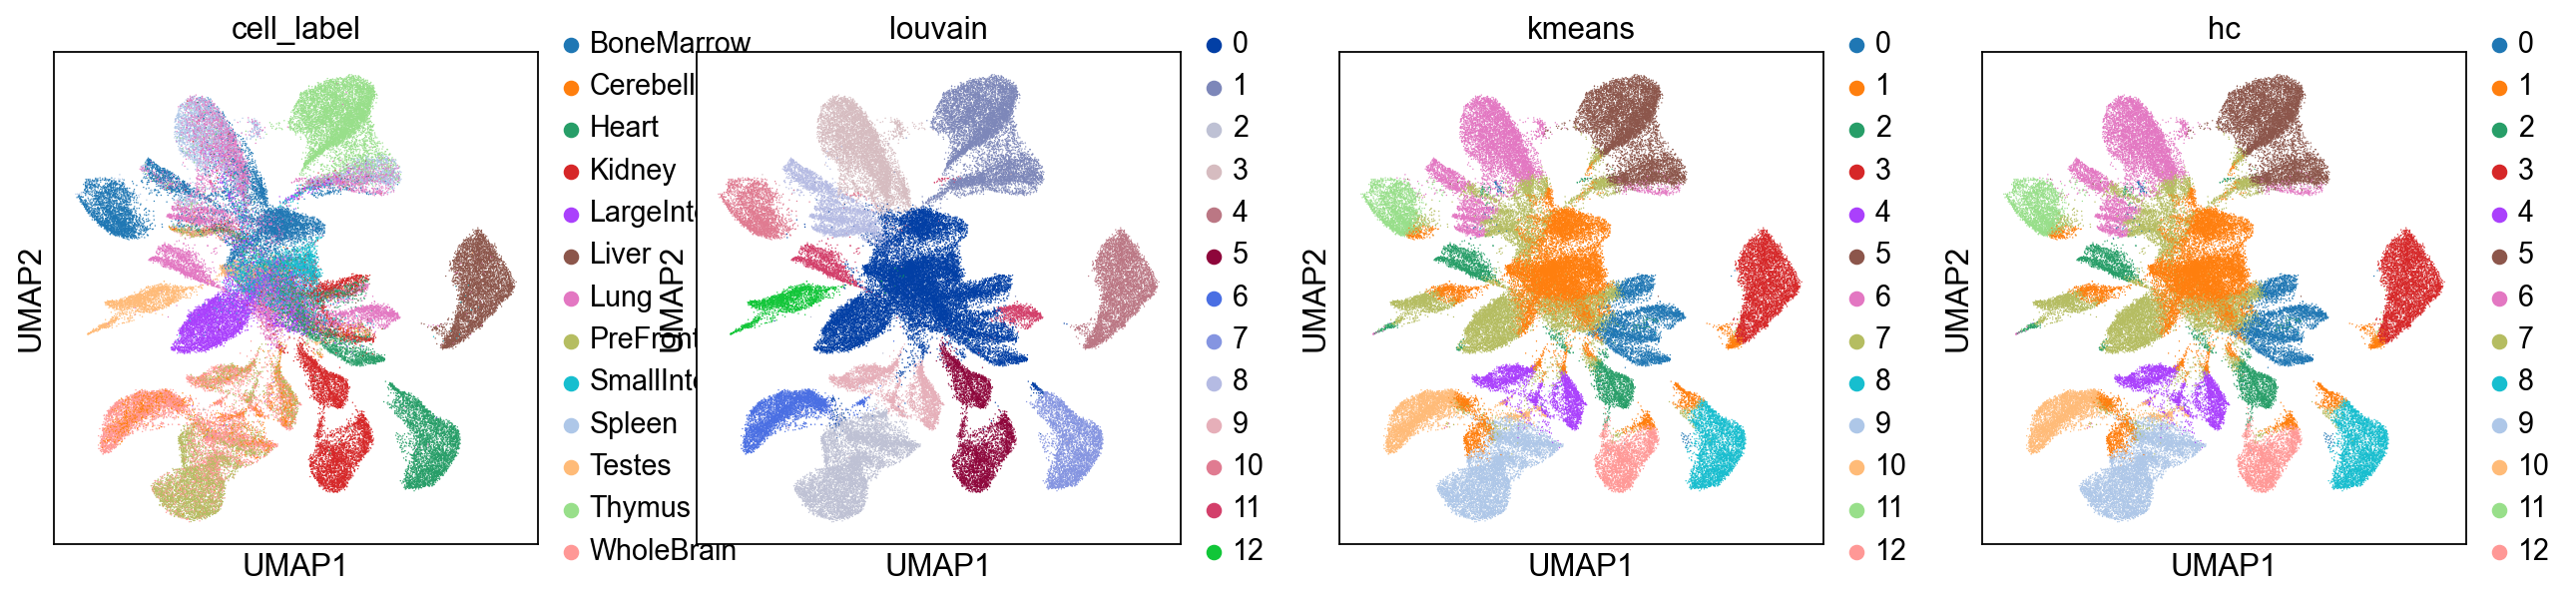

['SnapATAC', '0.385046', '0.342715', '0.238682', '0.619034', '0.553361', '0.554868', '0.595526', '0.539072', '0.515852']


,ARI_Louvain,ARI_kmeans,ARI_HC,AMI_Louvain,AMI_kmeans,AMI_HC,Homogeneity_Louvain,Homogeneity_kmeans,Homogeneity_HC
epiScanpy,0.342327,0.295384,0.295384,0.603708,0.511334,0.511334,0.579959,0.500422,0.500422
SnapATAC,0.385046,0.342715,0.238682,0.619034,0.553361,0.554868,0.595526,0.539072,0.515852


In [9]:


#adjusted rank index
ari_louvain = adjusted_rand_score(adata.obs['label'], adata.obs['louvain'])
ari_kmeans = adjusted_rand_score(adata.obs['label'], adata.obs['kmeans'])
ari_hc = adjusted_rand_score(adata.obs['label'], adata.obs['hc'])
#adjusted mutual information
ami_louvain = adjusted_mutual_info_score(adata.obs['label'], adata.obs['louvain'],average_method='arithmetic')
ami_kmeans = adjusted_mutual_info_score(adata.obs['label'], adata.obs['kmeans'],average_method='arithmetic')   
ami_hc = adjusted_mutual_info_score(adata.obs['label'], adata.obs['hc'],average_method='arithmetic')
#homogeneity
homo_louvain = homogeneity_score(adata.obs['label'], adata.obs['louvain'])
homo_kmeans = homogeneity_score(adata.obs['label'], adata.obs['kmeans'])
homo_hc = homogeneity_score(adata.obs['label'], adata.obs['hc'])

df_metrics.loc[method,['ARI_Louvain','ARI_kmeans','ARI_HC']] = [ari_louvain,ari_kmeans,ari_hc]
df_metrics.loc[method,['AMI_Louvain','AMI_kmeans','AMI_HC']] = [ami_louvain,ami_kmeans,ami_hc]
df_metrics.loc[method,['Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC']] = [homo_louvain,homo_kmeans,homo_hc] 
#adata.obs[['louvain','kmeans','hc']].to_csv(os.path.join(path_clusters ,method + '_clusters.tsv'),sep='\t')

sc.pl.umap(adata, color=['cell_label', 'louvain', 'kmeans', 'hc'])

all_metrics = """ARI_Louvain	ARI_kmeans	ARI_HC	AMI_Louvain	AMI_kmeans	AMI_HC	Homogeneity_Louvain	Homogeneity_kmeans	Homogeneity_HC
SnapATAC	0.385046	0.342715	0.238682	0.619034	0.553361	0.554868	0.595526	0.539072	0.515852
"""

all_metrics = [line.split('\t') for line in  all_metrics.split('\n')[:-1]]

for line in all_metrics[1:]:
    print(line)
    df_metrics.loc[line[0],['ARI_Louvain','ARI_kmeans','ARI_HC']] = line[1:4]
    df_metrics.loc[line[0],['AMI_Louvain','AMI_kmeans','AMI_HC']] = line[4:7]
    df_metrics.loc[line[0],['Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC']] = line[7:]

df_metrics